In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing necessary libraries

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import shap
import nltk
from nltk.tokenize import sent_tokenize
import xgboost as xgb
import numpy as np

In [ ]:
loaded_vectorizer = joblib.load('/content/drive/MyDrive/PhDEXPERIMENT/tfidf and Models/tfidf_vectorizer.joblib')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
train_path="/content/drive/MyDrive/PhDEXPERIMENT/train and test data/train_set.csv"
test_path ="/content/drive/MyDrive/PhDEXPERIMENT/train and test data/test_set.csv"

In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [ ]:
X_train = train_df['text']
y_train = train_df['label']
X_test = test_df['text']
y_test = test_df['label']

In [ ]:
# Transform the test data using the loaded vectorizer
X_test_transformed = loaded_vectorizer.transform(X_test).toarray()

# Training model

In [ ]:
dtrain = xgb.DMatrix(loaded_vectorizer.transform(X_train).toarray(), label=y_train)
dtest = xgb.DMatrix(X_test_transformed, label=y_test)
params = {
    'objective': 'multi:softmax',  # Specify multiclass classification
    'num_class': 3,                # Number of classes
    'max_depth': 3,                # Maximum depth of a tree
    'eta': 0.3,                    # Learning rate
    'seed': 42                     # Random seed for reproducibility
}
num_round = 50
bst = xgb.train(params, dtrain, num_round)

In [ ]:
# Get feature names from the vectorizer
feature_names = loaded_vectorizer.get_feature_names_out()

In [ ]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer(X_test_transformed)

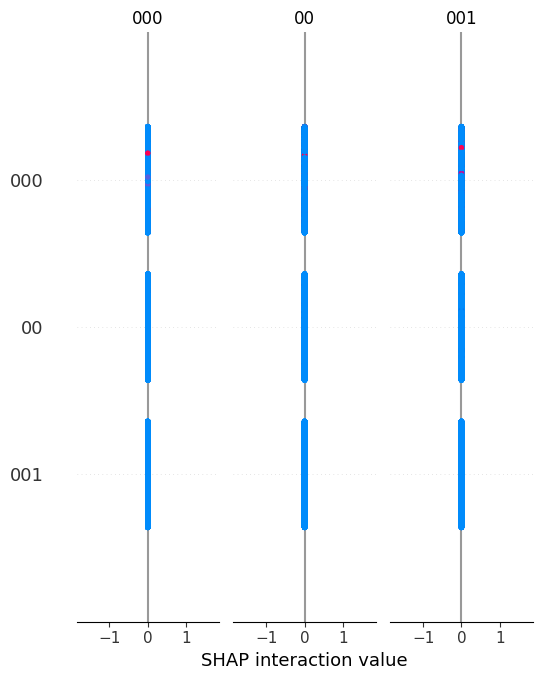

In [ ]:
# Visualize the SHAP values for the test data
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)


In [ ]:
print("First Test Data (Raw Text):")
print(X_test[0])

First Test Data (Raw Text):
Remember that cards are printed in large sheets and then cut . If you want to make just 52 cards , your closest option to making them square is 4x13 . With 54 cards , you can print a 6x9 sheet which has much more manageable dimensions . Many decks these days are printed on 7x8 sheets giving you 56 cards in the pack . Jokers are used as wild cards in a huge number of games . URL_0 It was originally added for Euchre . It can also be used as replacement for a card that goes missing . If nothing else , if you end up losing another card you can write on the joker and boom another 5 of diamonds


In [ ]:
# Prediction for the first row (first sample) in the test set
first_row_prediction = bst.predict(xgb.DMatrix(X_test_transformed[0:1]))
print(f"Prediction for the first row: {first_row_prediction[0]}")

Prediction for the first row: 0.0


In [ ]:

# Sigmoid function to convert logit to probability
def sigmoid(logit):
    return 1 / (1 + np.exp(-logit))

# Example logit value (e.g., the FX value of -10.24)
logit = -10.24

# Calculate the probability for class 1 using the sigmoid function
probability = sigmoid(logit)

# Print the probability for class 1
print(f"Probability for class 1: {probability:.4f}")

# If you want to classify it into a binary output (0 or 1):
prediction_class = 1 if probability > 0.5 else 0
print(f"Predicted class: {prediction_class}")


Probability for class 1: 0.0000
Predicted class: 0


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def get_sentence_embedding(sentence):
    return loaded_vectorizer.transform([sentence]).toarray()[0]


In [ ]:
def model_predict(embeddings):
    """Predict probabilities using the trained XGBClassifier."""
    n_features_expected = bst.n_features_in_
    if embeddings.shape[1] != n_features_expected:
        # Adjust PCA to keep fewer componentsloaded_model
        n_components = min(n_features_expected, embeddings.shape[0], embeddings.shape[1])  # Include embeddings.shape[0] in min
        pca = PCA(n_components=n_components)
        embeddings = pca.fit_transform(embeddings)

        # If n_components is still less than expected, pad with zeros
        if embeddings.shape[1] < n_features_expected:
            padding_shape = (embeddings.shape[0], n_features_expected - embeddings.shape[1])
            padding = np.zeros(padding_shape)
            embeddings = np.concatenate([embeddings, padding], axis=1)

    return bst.predict_proba(embeddings)[:, 1]

# Calculating impact of sentence

In [ ]:
def XAI_Reasoning(new_sample):
  # Transform new sample into TF-IDF features
  new_sample_tfidf = loaded_vectorizer.transform(new_sample).toarray()
  dmatrix = xgb.DMatrix(new_sample_tfidf)
  sample_pred = bst.predict(dmatrix)  # This will give probabilities for binary classification
  sample_proba = sample_pred  # For binary classification, this gives the probability of the positive class
  sample_label = (sample_pred > 0.5).astype(int)  # Convert probabilities to binary labels if needed
  print(f"Predicted Label: {sample_label[0]}")  # 1 for AI-generated, 0 for human-written
  print(f"Predicted Probability of being AI-generated: {sample_proba[0]:.4f}")

  print("SHAP Explanations:")

  # Tokenize sentences
  sentences = sent_tokenize(new_sample[0])

  # Compute sentence embeddings
  sentence_embeddings = np.array([get_sentence_embedding(sentence) for sentence in sentences])

  # SHAP explanations
  explainer = shap.TreeExplainer(bst)
  shap_values = explainer.shap_values(sentence_embeddings)

  abs_shap_values = np.abs(shap_values)


  sentence_impact = np.sum(abs_shap_values, axis=1)

  sentence_impact_scalar = [np.sum(impact) for impact in sentence_impact]

  # Combine the scalar impacts with the sentences and sort them
  sentence_impact_sorted = sorted(zip(sentence_impact_scalar, sentences), reverse=True)

  print("Sentence Impact Ranking (Most Impactful Sentence First):")
  for impact, sentence in sentence_impact_sorted:
      # Calculate a summary statistic for impact (e.g., mean)
      if isinstance(impact, (np.ndarray, list)):
          impact_value = np.mean(impact)  # You can choose mean, max, or another summary statistic
      else:
          impact_value = float(impact)
      print(f"Impact: {impact_value:.4f} | Sentence: {sentence}")

  # Prepare data for the bar plot
  sentence_labels = [f"Sentence {i + 1}" for i in range(len(sentences))]
  impact_values = [np.mean(impact) if isinstance(impact, (np.ndarray, list)) else float(impact)
                  for impact, _ in sentence_impact_sorted]

  # Plotting the impacts as a horizontal bar chart
  plt.barh(sentence_labels, impact_values)
  plt.xlabel('Impact Value')
  plt.ylabel('Sentence')
  plt.title('Sentence Impact Analysis')
  plt.gca().invert_yaxis()  # To have the highest impact on top
  plt.show()

Predicted Label: 1
Predicted Probability of being AI-generated: 1.0000
SHAP Explanations:
Sentence Impact Ranking (Most Impactful Sentence First):
Impact: 6.4467 | Sentence: Our experiments reveal that current detection models show considerable unreliability in real-world scenarios, particularly when tested against diverse data domains and novel evasion strategies.
Impact: 5.8565 | Sentence: This research benchmarks the performance of leading AI detectors, including OpenAI Detector, RADAR, and ArguGPT, across a variety of text domains, evaded content, and text generated by cutting-edge LLMs.
Impact: 5.6571 | Sentence: Additionally, this work lays the groundwork for future research by offering a comprehensive evaluation of existing detectors under challenging conditions, fostering a deeper understanding of their limitations.
Impact: 5.6133 | Sentence: 
The rapid advancement of Large Language Models (LLMs), such as GPT-4, has sparked concerns regarding academic misconduct, misinformation

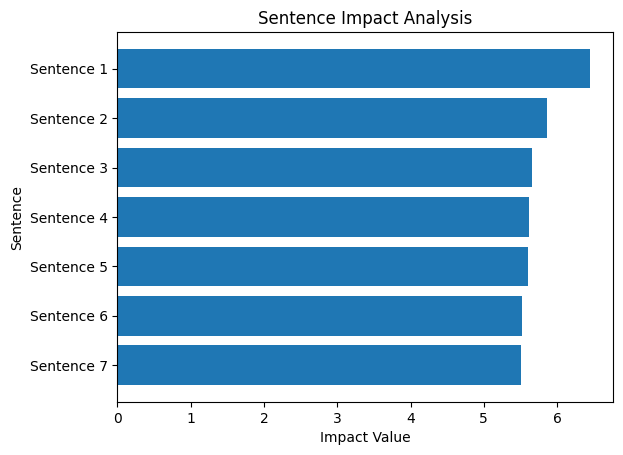

In [ ]:
text = ["""
The rapid advancement of Large Language Models (LLMs), such as GPT-4, has sparked concerns regarding academic misconduct, misinformation, and the erosion of originality. Despite the growing number of AI detection tools, their effectiveness is often undermined by sophisticated evasion tactics and the continuous evolution of LLMs. This research benchmarks the performance of leading AI detectors, including OpenAI Detector, RADAR, and ArguGPT, across a variety of text domains, evaded content, and text generated by cutting-edge LLMs. Our experiments reveal that current detection models show considerable unreliability in real-world scenarios, particularly when tested against diverse data domains and novel evasion strategies. The study underscores the need for enhanced robustness in detection systems and provides valuable insights into areas of improvement for these models. Additionally, this work lays the groundwork for future research by offering a comprehensive evaluation of existing detectors under challenging conditions, fostering a deeper understanding of their limitations. The experimental code and datasets are publicly available for further benchmarking on Github.

"""]

XAI_Reasoning(text)

Predicted Label: 1
Predicted Probability of being AI-generated: 1.0000
SHAP Explanations:
Sentence Impact Ranking (Most Impactful Sentence First):
Impact: 6.4530 | Sentence: As a vital source of milk, meat, and leather, cows have played a crucial role in sustaining economies and providing nutrition for centuries.
Impact: 6.4529 | Sentence: In many cultures, cows hold a sacred status, symbolizing fertility, abundance, and motherhood.
Impact: 6.0365 | Sentence: They are ruminants, meaning they have a unique digestive system that allows them to break down tough plant matter, like grass, through a process of fermentation in a specialized stomach.
Impact: 5.9693 | Sentence: Their ability to adapt to various environments has made them integral to farming practices worldwide, contributing to food security and rural livelihoods.
Impact: 5.9519 | Sentence: Known for their gentle nature, cows are social animals that form strong bonds within their herds.
Impact: 5.5270 | Sentence: The cow is a do

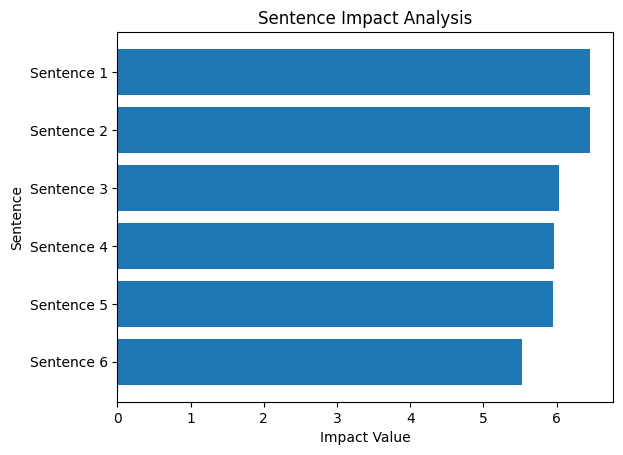

In [ ]:
text = ["""The cow is a domesticated animal widely known for its significance in agriculture and human society. As a vital source of milk, meat, and leather, cows have played a crucial role in sustaining economies and providing nutrition for centuries.
 In many cultures, cows hold a sacred status, symbolizing fertility, abundance, and motherhood. They are ruminants, meaning they have a unique digestive system that allows them to break down tough plant matter, like grass, through a process of fermentation in a specialized stomach. Known for their gentle nature, cows are social animals that form strong bonds within their herds. Their ability to adapt to various environments has made them integral to farming practices worldwide, contributing to food security and rural livelihoods."""]
XAI_Reasoning(text)

Predicted Label: 0
Predicted Probability of being AI-generated: 0.0000
SHAP Explanations:
Sentence Impact Ranking (Most Impactful Sentence First):
Impact: 6.7673 | Sentence: from a particular region or population and was then spread through migration and genetic inter
Impact: 5.9983 | Sentence: the genetics of hair color variation is a complex field of study and there is still much to learn about the factors that influence hair color diversity among.
Impact: 5.8419 | Sentence: different populations one theory is that the gene responsible for hair color variation may have originated.


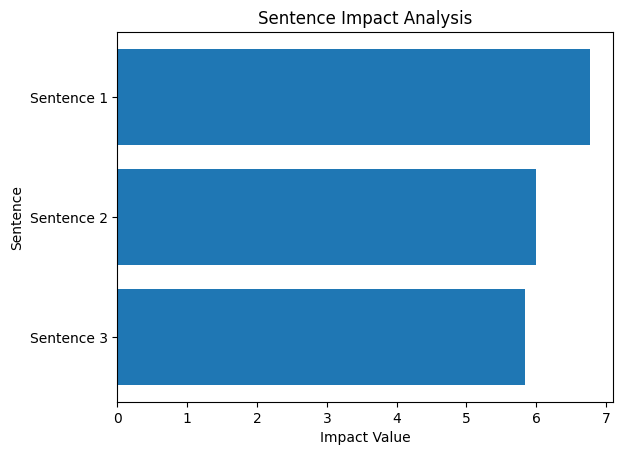

In [ ]:
text = ["""the genetics of hair color variation is a complex field of study and there is still much to learn about the factors that influence hair color diversity among. different populations one theory is that the gene responsible for hair color variation may have originated. from a particular region or population and was then spread through migration and genetic inter"""]
XAI_Reasoning(text)